In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jaxinterp2d import interp2d

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_3855/1914414784.py:5: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


## 1. Generate data + pretraining

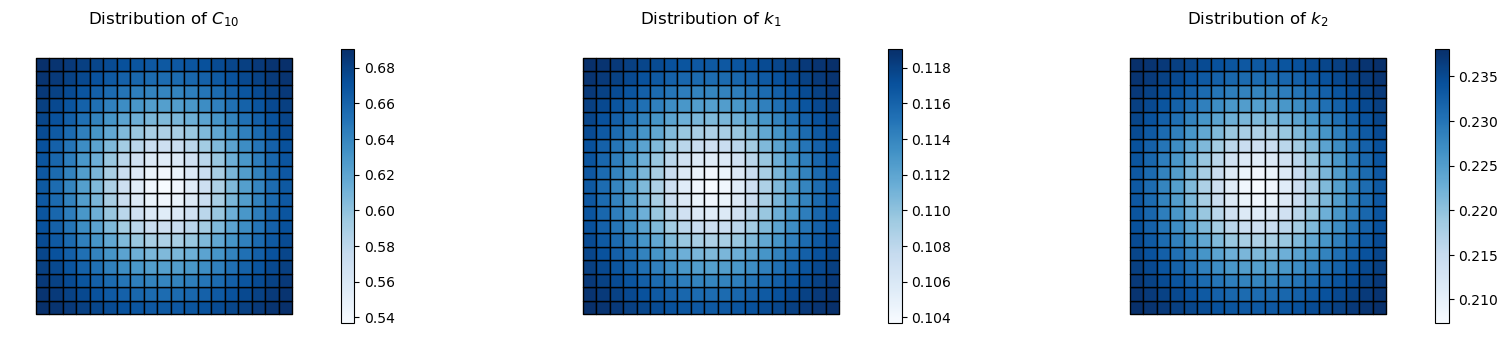

In [2]:
# Generate a synthetic heterogeneous field and assume some boundary conditions
nvar = 2
nrow = 20
ncol = 20
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
pts_x = np.linspace(0,1,nrow)
pts_y = np.linspace(0,1,ncol)
node_X, node_Y = np.meshgrid(pts_x,pts_y)
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

# Identify the boundary nodes
rgt_bd = np.where(node_X[:,0]>0.99)
top_bd = np.where(node_X[:,1]>0.99)
lft_bd = np.where(node_X[:,0]<0.01)
bot_bd = np.where(node_X[:,1]<0.01)
rgt_bd_x = node_X[rgt_bd,0].flatten()
rgt_bd_y = node_X[rgt_bd,1].flatten()
top_bd_x = node_X[top_bd,0].flatten()
top_bd_y = node_X[top_bd,1].flatten()
lft_bd_x = node_X[lft_bd,0].flatten()
lft_bd_y = node_X[lft_bd,1].flatten()
bot_bd_x = node_X[bot_bd,0].flatten()
bot_bd_y = node_X[bot_bd,1].flatten()

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

C10 = np.zeros(n_node)
k1  = np.zeros(n_node)
k2  = np.zeros(n_node)

r = np.sqrt((node_X[:,0]-0.5)**2 + (node_X[:,1]-0.5)**2)
r = r/np.max(r)
r_transition = 0.35
s = 5 #controls (inversely) the smoothness of the transition. 
sigmoid = 1/(1+np.exp(-s*(r-r_transition)))
C10 = 0.5 + 0.2*sigmoid
k1  = 0.1 + 0.02*sigmoid
k2  = 0.2 + 0.04*sigmoid

fig, ax = plt.subplots(1,3,figsize=(20,4))
c_elem = 0.25*(C10[elements[:,0]] + C10[elements[:,1]] + C10[elements[:,2]] + C10[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $C_{10}$', ax=ax[0]); 
c_elem = 0.25*(k1[elements[:,0]] + k1[elements[:,1]] + k1[elements[:,2]] + k1[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $k_1$', ax=ax[1]); 
c_elem = 0.25*(k2[elements[:,0]] + k2[elements[:,1]] + k2[elements[:,2]] + k2[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $k_2$', ax=ax[2]); 

Fx = np.random.uniform()+0.5

In [3]:
class GOH_SEDF():
    def __init__(self):
        return
    
    def fiberangle(self, node_X):
        return 0.0
    
    def X2params(self, X):
        X_C10    = interp2d(X[0], X[1], pts_x, pts_y,   C10.reshape([nrow,ncol]))
        X_k1     = interp2d(X[0], X[1], pts_x, pts_y,    k1.reshape([nrow,ncol]))
        X_k2     = interp2d(X[0], X[1], pts_x, pts_y,    k2.reshape([nrow,ncol]))
        X_kappa  = 0.1
        return X_C10, X_k1, X_k2, X_kappa

    def Psi_i(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
        Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
        Psi2 = 0.0
        Psiw = 0.0
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi11 =          kappa**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psi1v = kappa*(1-3*kappa)*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psivv =    (1-3*kappa)**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)

        Psi12 = Psi22 = Psi1w = Psi2v = Psi2w = Psivw = Psiww = 0.0
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [ ]:
mySEDF = GOH_SEDF()
const_model = vahid_anisohyper_inv(mySEDF)
node_x_hist_goh = []
F_hist_goh = []
sigma_hist_goh = []
node_x = np.copy(node_X)
lmb_hist = [1.05, 1.10, 1.15, 1.20]
t_hist = np.arange(len(lmb_hist))
l=h=1.0
for i in range(len(lmb_hist)):
    lmb = lmb_hist[i]
    node_x, DOF_fmap = apply_bc_biax(node_x, lmx=lmb, lmy=lmb, l0=l, h0=h)
    mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
    mysolver.n_print = 1
    mysolver.itermax = 20
    node_x, F, sigma = mysolver.solve()
    node_x_hist_goh.append(node_x)
    F_hist_goh.append(F)
    sigma_hist_goh.append(sigma)

    l=h=lmb
node_x_hist_goh = np.array(node_x_hist_goh)
F_hist_goh = np.array(F_hist_goh)
sigma_hist_goh = np.array(sigma_hist_goh)

In [ ]:
from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh

In [ ]:
# Do the FEM with jax-fem instead
class HyperElasticity(FEM):
    def get_tensor_map(self):
        def first_PK_stress(u_grad, params):
            F = u_grad + jnp.eye(self.dim)
            C10, k1, k2, kappa, theta = params
            C = F.T @ F
            Cinv = jnp.linalg.inv(C)
            I1 = C[0,0] + C[1,1] + C[2,2]

            v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
            V0 = jnp.outer(v0, v0)
            Iv = jnp.einsum('ij,ij',C,V0)

            E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
            E = jnp.maximum(E, 0.0)

            Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
            Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
            Psi2 = 0.0

            p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2])
            S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0
            P = F@S
            return P
        
        return first_PK_stress
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

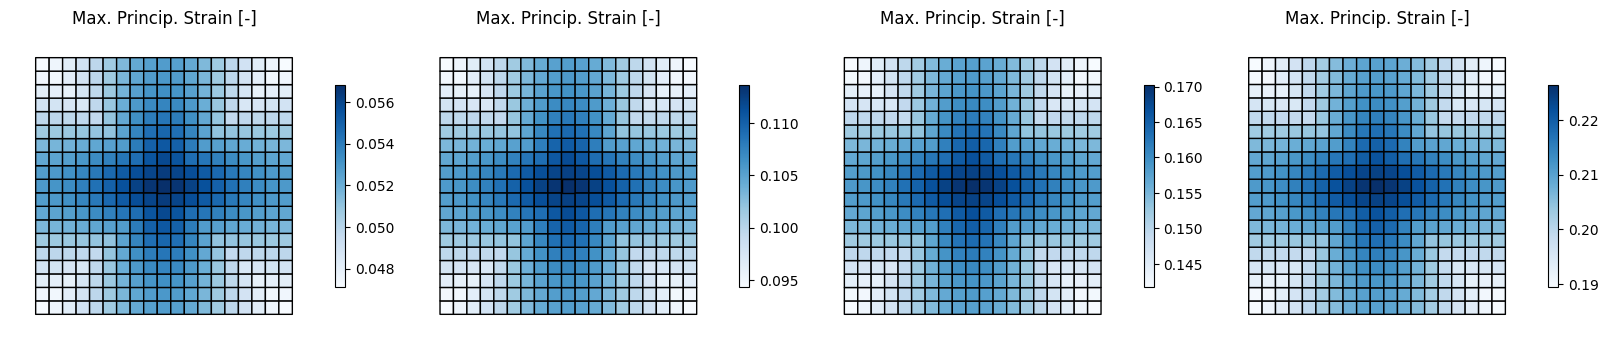

In [13]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist_goh, F_hist_goh, sigma_hist_goh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(elements, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

it 1000, train loss = 3.859258e-04
it 2000, train loss = 1.192392e-04
it 3000, train loss = 5.255704e-05
it 4000, train loss = 2.620486e-05
it 5000, train loss = 1.401994e-05
it 6000, train loss = 7.784899e-06
it 7000, train loss = 4.554967e-06
it 8000, train loss = 2.607183e-06
it 9000, train loss = 1.545925e-06
it 10000, train loss = 9.965286e-07
it 11000, train loss = 6.182114e-07
it 12000, train loss = 4.662736e-07
it 13000, train loss = 3.181429e-07
it 14000, train loss = 1.748061e-07
it 15000, train loss = 1.189364e-07
it 16000, train loss = 9.086461e-08
it 17000, train loss = 7.960357e-08
it 18000, train loss = 2.364640e-07
it 19000, train loss = 4.921399e-08
it 20000, train loss = 3.992397e-08
it 21000, train loss = 2.593963e-08
it 22000, train loss = 9.333749e-08
it 23000, train loss = 2.602899e-08
it 24000, train loss = 2.324162e-08
it 25000, train loss = 2.032519e-08
it 26000, train loss = 1.828495e-08
it 27000, train loss = 1.738190e-08
it 28000, train loss = 2.106092e-08
i

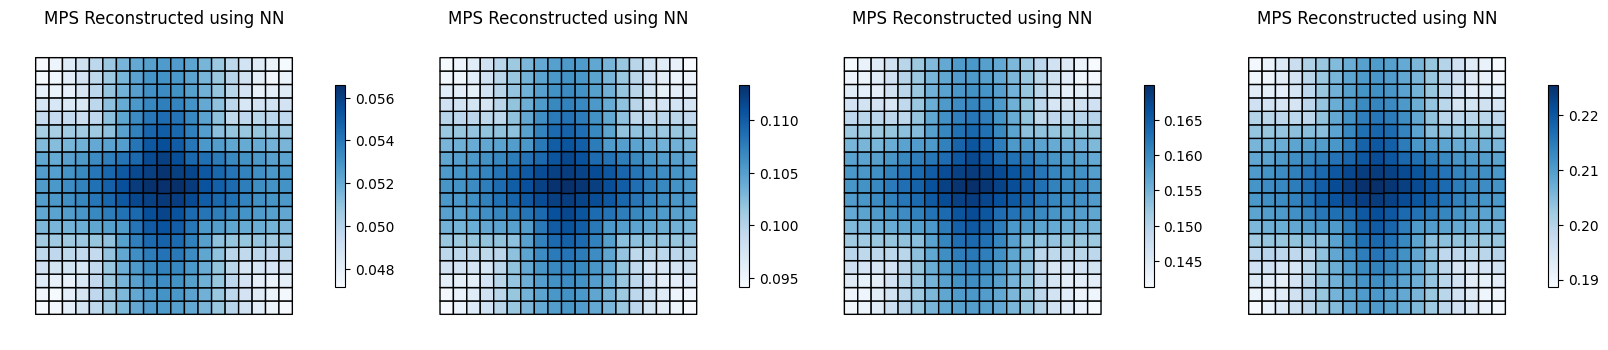

In [14]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = ff_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 20 # 10 cosines and 10 sines in the fourier features
n_inp = 3 # x, y, lmb
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])
nn_layers = [2*n_ff,20,20,2]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

element_x = np.array([np.mean(node_X[element][:,0]) for element in elements])
element_y = np.array([np.mean(node_X[element][:,1]) for element in elements])
element_X = np.array([element_x, element_y]).T
X = np.vstack([element_X, element_X, element_X, element_X])
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss, inp, get_params, opt_update, opt_state, key, nIter = 40000, print_freq=1000, batch_size=1000)


fig, axes = plt.subplots(1,4,figsize=(20,4))
for t in t_hist:
    ax = axes[t]
    aux = np.hstack([element_X, t*np.ones_like(element_X[:,:1])])
    eps_xx_pr, eps_yy_pr = ff_nn(aux, coord_2_strain_params).T
    mps_pr = np.maximum(eps_xx_pr, eps_yy_pr)

    plotmesh(elements, node_x, mps_pr, title='MPS Reconstructed using NN', ax=ax); 

In [15]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(elements):
    if any([node_X[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([node_X[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([node_X[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([node_X[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(sigma_hist_goh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(sigma_hist_goh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(sigma_hist_goh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(sigma_hist_goh[:,bot_bd_elems,1,1], axis=1)
Fx = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Fy = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

# get the center points of the elements
elem_X = np.array([0.25*(node_X[e[0]] + node_X[e[1]] + node_X[e[2]] + node_X[e[3]]) for e in elements])
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [16]:
# Homogenize the strains
eps_xx_mean = np.mean(F_hist_goh[:,:,0,0]-1.0, axis=1)
eps_yy_mean = np.mean(F_hist_goh[:,:,1,1]-1.0, axis=1)
# eps_xy_mean = np.mean(0.5*(F_hist_goh[:,:,0,1]+F_hist_goh[:,:,1,0]), axis=1)
sgmx_mean = Fx/len(rgt_bd_elems)
sgmy_mean = Fy/len(top_bd_elems)
lamb_sigma_m = np.array([eps_xx_mean+1.0, eps_yy_mean+1.0, sgmx_mean, sgmy_mean]).reshape([len(lmb_hist),-1]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, key):
    model   = NODE_model_aniso(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sgmx_gt  = lamb_sigma[:,2]
    sgmy_gt  = lamb_sigma[:,3]
    sgm = eval_Cauchy_aniso_vmap(lambx,lamby, model)
    sgmx_pr, sgmy_pr = sgm[:,0,0], sgm[:,1,1]
    return np.mean((sgmx_pr-sgmx_gt)**2+(sgmy_pr-sgmy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000)

it 1000, train loss = 1.179229e-01
it 2000, train loss = 7.511797e-02
it 3000, train loss = 4.550764e-02
it 4000, train loss = 3.166976e-02
it 5000, train loss = 2.073346e-02
it 6000, train loss = 8.521668e-05
it 7000, train loss = 4.481597e-05
it 8000, train loss = 4.084777e-05
it 9000, train loss = 2.751731e-05
it 10000, train loss = 1.308563e-05


In [17]:
mymodel = NODE_model_aniso(node_params)
sgm = eval_Cauchy_aniso_vmap(eps_xx_mean+1.0,eps_yy_mean+1.0, mymodel)
sgmx, sgmy = sgm[:,0,0], sgm[:,1,1]
print('gt sgmx & sgmy: ', sgmx_mean, sgmy_mean)
print('pr sgmx & sgmy: ', sgmx, sgmy)

gt sgmx & sgmy:  [0.36956799 0.70291078 1.01246737 1.30770928] [0.35646291 0.67240205 0.9595573  1.22648022]
pr sgmx & sgmy:  [0.36865061 0.70767437 1.01171518 1.30593272] [0.35257662 0.67360045 0.95754042 1.22859683]


In [18]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 2000, print_freq=1000)

it 1000, train loss = 4.529166e-04
it 2000, train loss = 1.221455e-04


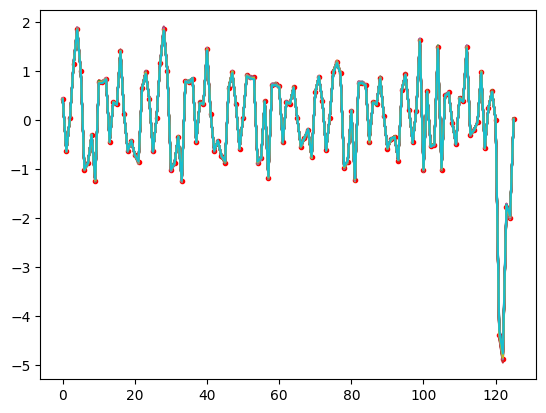

In [19]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [20]:
with open('params/circ_multistep_s5_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, node_X, elements, n_node, Fx, Fy, strains,
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist], f)

## 2. Retrain

In [5]:
with open('params/circ_multistep_s5_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, node_X, elements, n_node, Fx, Fy, strains, \
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [6]:
# Train
@jit
def loss(Lambda_params, X):
    div_x, div_y = divergence(Lambda_params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
    F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
    t = X[1] # a scalar
    fx = Fx[jnp.array(t, int)]
    fy = Fy[jnp.array(t, int)]
    return a1*(div_x**2 + div_y**2) + a2*((F_rgt-fx)**2 + (F_top-fy)**2 + (F_lft-fx)**2 + (F_bot-fy)**2)

lr = 1e-4
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

metric1 = lambda params, X:  bd_forces(params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, X, bd_X, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [node_X, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 60000, print_freq=1000, metric_fns=[metric1, metric2])

# with open('params/circ_multistep_s5_post.npy', 'wb') as f:
#     pickle.dump([node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics], f)

it 1000, val loss = 9.479016e-01
it 2000, val loss = 5.109966e-01
it 3000, val loss = 6.570000e-01
it 4000, val loss = 7.938433e-01
it 5000, val loss = 8.888126e-01
it 6000, val loss = 5.629634e-01
it 7000, val loss = 6.348002e-01


## 3. Test

In [5]:
with open('params/circ_multistep_s5_post.npy', 'rb') as f:
    node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics = pickle.load(f)

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_93654/3260991309.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  forces, div = np.array(metrics).T


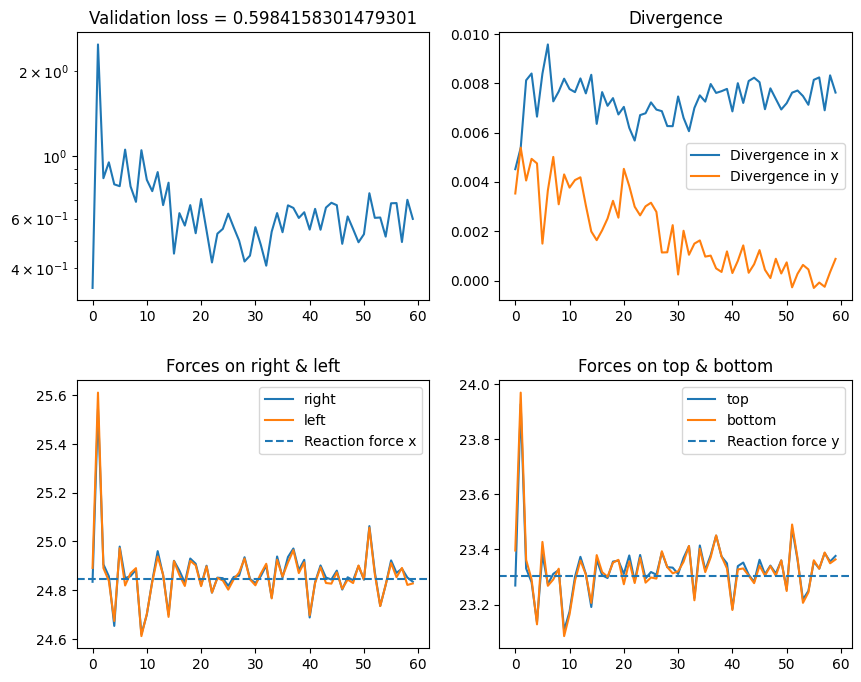

In [23]:
forces, div = np.array(metrics).T
forces = np.array([*forces])
div = np.array([*div])

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(val_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx[-1], linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy[-1], linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Validation loss = ' + str(val_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

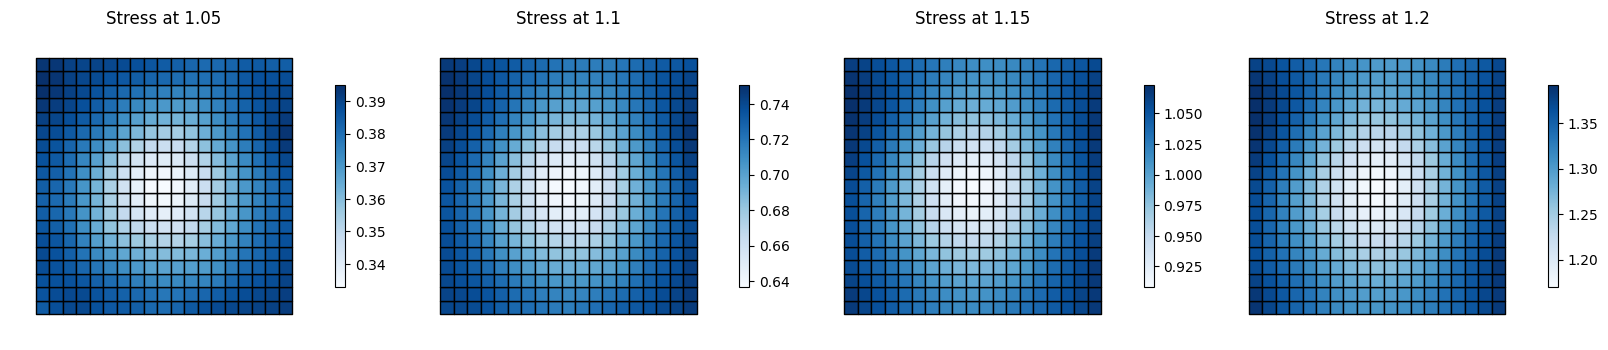

In [24]:
# Stiffness across the domain
fig, axes = plt.subplots(1,4,figsize=(20,4))
for lmb, ax in zip(lmb_hist, axes):
    sgm_list = []
    for x, y in node_X:
        Lambda_inp = jnp.array([x,y]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE_w_unravel(phi)
        sgm = eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0]
        sgm_list.append(sgm)
    sgm_list = np.array(sgm_list)
    c_elem = 0.25*(sgm_list[elements[:,0]] + 
                   sgm_list[elements[:,1]] + 
                   sgm_list[elements[:,2]] + 
                   sgm_list[elements[:,3]])
    plotmesh(elements, node_X, c_elem, title='Stress at {}'.format(str(lmb)), ax=ax); 

In [7]:
class NODE_SEDF_aniso():
    def __init__(self, Lambda_params=None, unravel=None):
        self.Lambda_params = Lambda_params
        self.unravel = unravel
        return
    def X2params(self, X):
        Lambda_inp = np.array([X[0],X[1]]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, self.Lambda_params).flatten()
        params = self.unravel(phi)
        return params
    def fiberangle(self, node_X):
        return 0.0
    
    def Psi_i(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        Psi1 = model.Psi1(I1,I2,Iv,Iw)
        Psi2 = model.Psi2(I1,I2,Iv,Iw)
        Psiv = model.Psiv(I1,I2,Iv,Iw)
        Psiw = model.Psiw(I1,I2,Iv,Iw)
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        
        e = 1.0e-6
        Psi1_p = model.Psi1(I1+e,I2,Iv,Iw)
        Psi1_m = model.Psi1(I1-e,I2,Iv,Iw)
        Psi2_p = model.Psi2(I1+e,I2,Iv,Iw)
        Psi2_m = model.Psi2(I1-e,I2,Iv,Iw)
        Psiv_p = model.Psiv(I1+e,I2,Iv,Iw)
        Psiv_m = model.Psiv(I1-e,I2,Iv,Iw)
        Psiw_p = model.Psiw(I1+e,I2,Iv,Iw)
        Psiw_m = model.Psiw(I1-e,I2,Iv,Iw)
        Psi11 = (Psi1_p-Psi1_m)/2/e
        Psi12 = (Psi2_p-Psi2_m)/2/e
        Psi1v = (Psiv_p-Psiv_m)/2/e
        Psi1w = (Psiw_p-Psiw_m)/2/e

        Psi2_p = model.Psi2(I1,I2+e,Iv,Iw)
        Psi2_m = model.Psi2(I1,I2-e,Iv,Iw)
        Psiv_p = model.Psiv(I1,I2+e,Iv,Iw)
        Psiv_m = model.Psiv(I1,I2-e,Iv,Iw)
        Psiw_p = model.Psiw(I1,I2+e,Iv,Iw)
        Psiw_m = model.Psiw(I1,I2-e,Iv,Iw)
        Psi22 = (Psi2_p-Psi2_m)/2/e
        Psi2v = (Psiv_p-Psiv_m)/2/e
        Psi2w = (Psiw_p-Psiw_m)/2/e

        Psiv_p = model.Psiv(I1,I2,Iv+e,Iw)
        Psiv_m = model.Psiv(I1,I2,Iv-e,Iw)
        Psiw_p = model.Psiw(I1,I2,Iv+e,Iw)
        Psiw_m = model.Psiw(I1,I2,Iv-e,Iw)
        Psivv = (Psiv_p-Psiv_m)/2/e
        Psivw = (Psiw_p-Psiw_m)/2/e

        Psiw_p = model.Psiw(I1,I2,Iv,Iw+e)
        Psiw_m = model.Psiw(I1,I2,Iv,Iw-e)
        Psiww = (Psiw_p-Psiw_m)/2/e
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [8]:
mySEDF = NODE_SEDF_aniso(Lambda_params, unravel)
const_model = vahid_anisohyper_inv(mySEDF)
node_x_hist = []
F_hist = []
sigma_hist = []
node_x = np.copy(node_X)
l=h=1.0
for i in range(len(lmb_hist)):
    lmb = lmb_hist[i]
    node_x, DOF_fmap = apply_bc_biax(node_x, lmx=lmb, lmy=lmb, l0=l, h0=h)
    mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
    mysolver.n_print = 1
    mysolver.itermax = 20
    node_x, F, sigma = mysolver.solve()
    node_x_hist.append(node_x)
    F_hist.append(F)
    sigma_hist.append(sigma)

    l=h=lmb
node_x_hist = np.array(node_x_hist)
F_hist      = np.array(F_hist)
sigma_hist  = np.array(sigma_hist)

with open('params/circ_multistep_s5_fem.npy', 'wb') as f:
    pickle.dump([node_X, t_hist, node_x_hist, F_hist, sigma_hist], f)

Solving...
iter 1,   residual = 15.463448614527083
iter 2,   residual = 3.776216251489972
iter 3,   residual = 1.280313015046568
iter 4,   residual = 0.5531088651357797
iter 5,   residual = 0.20158603976073938
iter 6,   residual = 0.038278127944510354
iter 7,   residual = 0.059958999656354775
iter 8,   residual = 0.032632848633216444
iter 9,   residual = 0.06434609614091368
iter 10,   residual = 0.03309383201119942
iter 11,   residual = 0.08011042846360515
iter 12,   residual = 0.03637935310416205
iter 13,   residual = 0.08177860643869782
iter 14,   residual = 0.037424130073087064
iter 15,   residual = 0.08326567327512074
iter 16,   residual = 0.03805479537950546
iter 17,   residual = 0.08421217032042247
iter 18,   residual = 0.0384401838745181
iter 19,   residual = 0.08479680849645634
iter 20,   residual = 0.0386619442849894
Reached maximum number of iterations without converging. Either increase itermax or decrease tolerance.
Solving...
iter 1,   residual = 65.23206817178801
iter 2, 

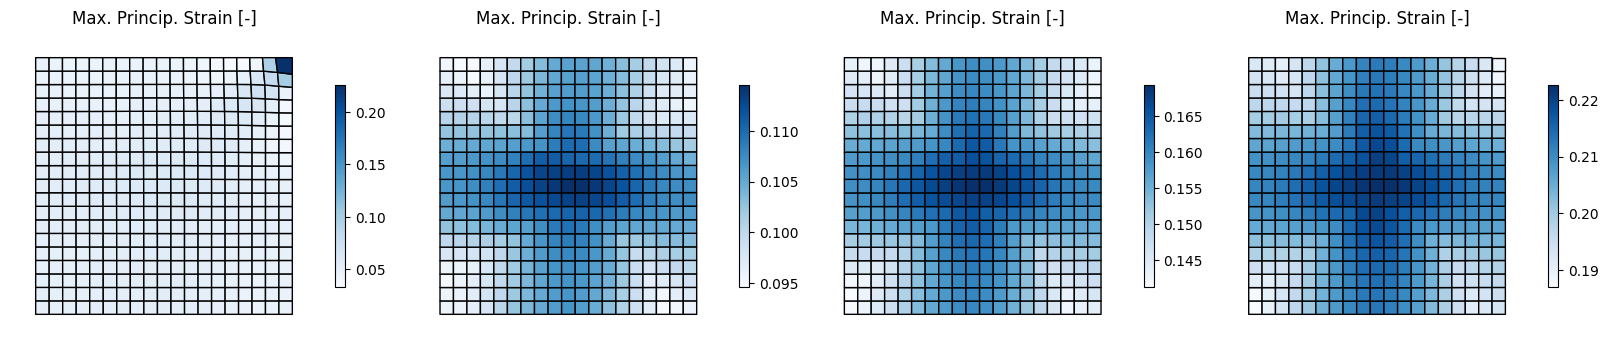

In [9]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(elements, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

In [11]:
from matplotlib.cm import get_cmap
cmap = get_cmap('viridis')

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_90381/2277699238.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


(-0.06887870601465894, 1.4464528263078378)

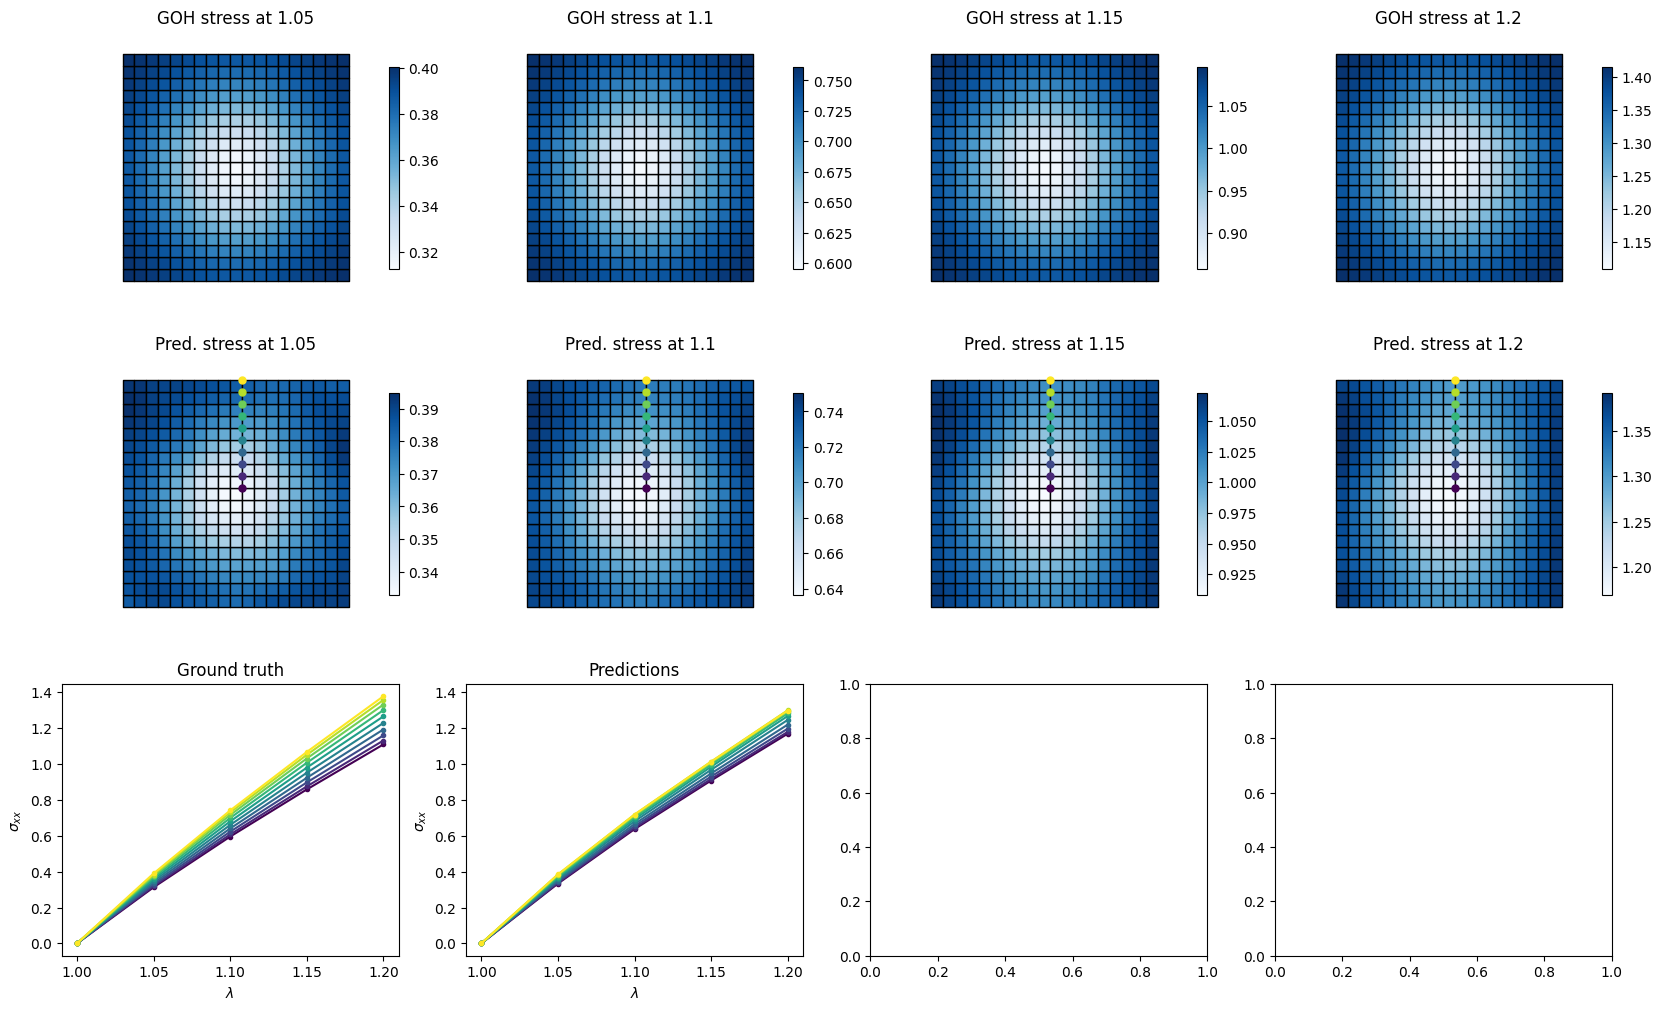

In [27]:
# Stiffness across the domain
fig, axes = plt.subplots(3,4,figsize=(20,12))
sgm_line_goh = []
sgm_line_node = []
for lmb, goh_ax, node_ax in zip(lmb_hist, axes[0], axes[1]):
    #Plot GOH contours
    sgm_list = []
    for x, y in node_X:
        X_C10    = interp2d(x, y, pts_x, pts_y,   C10.reshape([nrow,ncol]))
        X_k1     = interp2d(x, y, pts_x, pts_y,    k1.reshape([nrow,ncol]))
        X_k2     = interp2d(x, y, pts_x, pts_y,    k2.reshape([nrow,ncol]))
        X_kappa  = 0.1
        mymodel = GOH_model([X_C10, X_k1, X_k2, X_kappa])
        mymodel.theta=0.0
        sgm = eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0]
        sgm_list.append(sgm)
    sgm_list = np.array(sgm_list)
    c_elem = 0.25*(sgm_list[elements[:,0]] + 
                   sgm_list[elements[:,1]] + 
                   sgm_list[elements[:,2]] + 
                   sgm_list[elements[:,3]])
    plotmesh(elements, node_X, c_elem, title='GOH stress at {}'.format(str(lmb)), ax=goh_ax); 
    sgm_line_goh.append(sgm_list[210:220])


    #Plot NODE contours
    sgm_list = []
    for x, y in node_X:
        Lambda_inp = jnp.array([x,y]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE_w_unravel(phi)
        sgm = eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0]
        sgm_list.append(sgm)
    sgm_list = np.array(sgm_list)
    c_elem = 0.25*(sgm_list[elements[:,0]] + 
                   sgm_list[elements[:,1]] + 
                   sgm_list[elements[:,2]] + 
                   sgm_list[elements[:,3]])
    plotmesh(elements, node_X, c_elem, title='Pred. stress at {}'.format(str(lmb)), ax=node_ax); 
    sgm_line_node.append(sgm_list[210:220])
    for i, (x, y) in enumerate(node_X[210:220]):
        color = cmap(i / (len(node_X[210:220]) - 1))
        node_ax.plot(x, y, '.', markersize=10, color=color)


# line plots
sgm_line_goh = np.array(sgm_line_goh).T
for i, sgm in enumerate(sgm_line_goh):
    color = cmap(i / (len(node_X[210:220]) - 1))
    axes[2,0].plot([1]+lmb_hist, np.insert(sgm,0,0), marker='.', color=color)
axes[2,0].set(xlabel='$\lambda$', ylabel='$\sigma_{xx}$', title='Ground truth'); 


sgm_line_node = np.array(sgm_line_node).T
for i, sgm in enumerate(sgm_line_node):
    color = cmap(i / (len(node_X[210:220]) - 1))
    axes[2,1].plot([1]+lmb_hist, np.insert(sgm,0,0), marker='.', color=color)
axes[2,1].set(xlabel='$\lambda$', ylabel='$\sigma_{xx}$', title='Predictions'); 
axes[2,1].set_xlim(axes[2,0].get_xlim())
axes[2,1].set_ylim(axes[2,0].get_ylim())

Comments:
1. Look into nonlinearity of GOH
2. Look into virtual fields method
3. Make the circle smaller and smaller to see what is the limit of detection.